# 1. Tipos de fronteras en Clasificación

Primero, se generan los conjuntos de datos con los que se analizarán las distintas fronteras y algoritmos a utilizar

In [53]:
# Generacion de los datos para analisis
from sklearn.utils import check_random_state
import matplotlib.patches as mpatches
import numpy as np


def build_data(seed, noise_seed=64, n_samples=500, noise=20):
    n_samples=500
    mean = (0,-4)
    C = np.array([[0.3, 0.1], [0.1, 1.5]])
    np.random.seed(seed)
    datos1 = np.random.multivariate_normal(mean, C, n_samples)
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples))*3
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples))*3
    datos2 = np.vstack((outer_circ_x,outer_circ_y)).T

    generator = check_random_state(noise_seed)
    datos2 += generator.normal(scale=0.3, size=datos2.shape)

    X = np.concatenate((datos1, datos2), axis=0)
    n = noise #ruido/noise
    y1 = np.zeros(datos1.shape[0]+n)
    y2 = np.ones(datos2.shape[0]-n)
    y = np.concatenate((y1,y2),axis=0)
    return (X, y)

(X, y) = build_data(14)
(Xtest, ytest) = build_data(8000, noise_seed=7000)

A continuación, se visualizan brevemente los datos

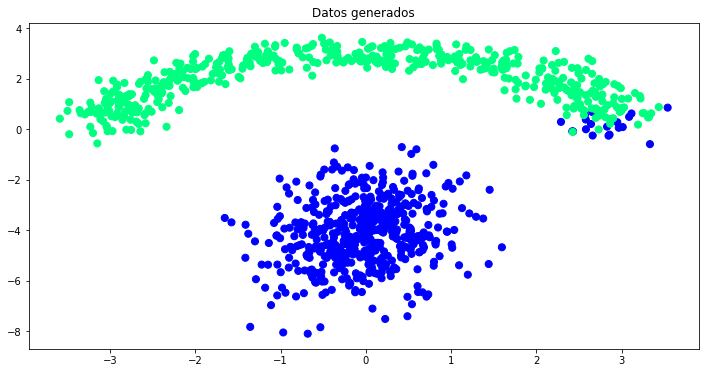

In [54]:
# Se grafican los datos obtenidos
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))
plt.scatter(X[:, 0], X[:,1], s=50, c=y, cmap=plt.cm.winter)
plt.title('Datos generados')
plt.show()

A continuación se define una función para visualizar la frontera que divide a los datos dado un modelo entrenado con el objeto de rápidamente ver los bordes de decisión encontrados por los distintos algoritmos


In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

def visualize_border(model,x,y, title="", x_test=None, y_test=None):
    fig = plt.figure(figsize=(12,6))
    plt.scatter(x[:,0], x[:,1], s=50, c=y, cmap=plt.cm.winter)
    h = .02 # step size in the mesh
    x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
    y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    if x_test is not None and y_test is not None:
        y_train_pred = model.predict(x)
        y_test_pred = model.predict(x_test)
        train_error = (1-accuracy_score(y, y_train_pred))
        test_error = (1-accuracy_score(y_test, y_test_pred))
        red_patch = mpatches.Patch(color='red', label="Train ME: %f" % train_error)
        green_patch = mpatches.Patch(color='green', label="Test ME: %f" % test_error)
        plt.legend(handles=[red_patch, green_patch])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

### Linear Discriminant Analysis (LDA)

A continuación se entrena un modelo usando LDA. Este algoritmo asume que la función de densidad de cada clase es gaussiana y que además existe una matriz de covarianza $\Sigma$ igual entre las clases.

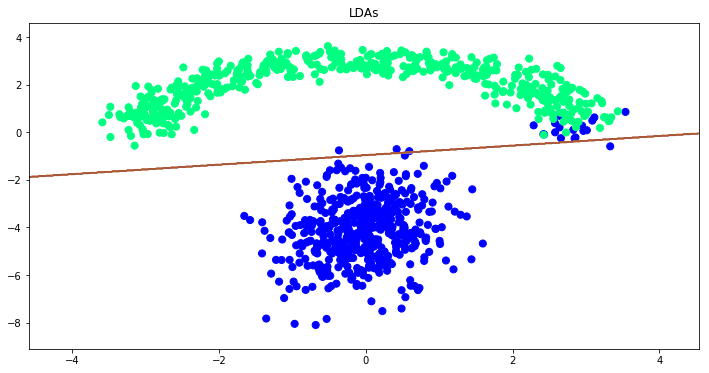

In [56]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
model_LDA = LDA()
model_LDA.fit(X,y)
visualize_border(model_LDA,X,y,"LDAs")

Con un error de clasificación de entrenamiento igual a:

In [57]:
1-model_LDA.score(X, y)

0.02200000000000002

Y con un error de clasificación de testing igual a:

In [58]:
1-model_LDA.score(Xtest, ytest)

0.02300000000000002

### Quadratic Discriminant Analysis (QDA)

A continuación se entrena un modelo usando QDA. Este algoritmo, al igual que LDA, asume que la densidad de los datos siguen distribuciones gaussianas, buscando encontrar la frontera que maximice la distancia entre dos distribuciones. A diferencia de **LDA**, QDA no asume nada respecto a las matrices de covarianza de dichas distribuciones.

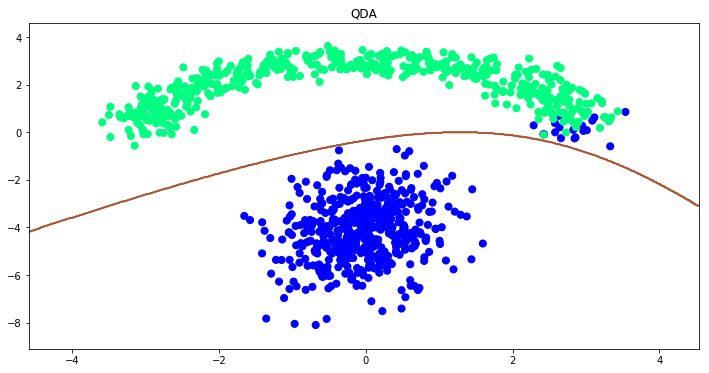

In [59]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
model_QDA = QDA()
model_QDA.fit(X,y)
visualize_border(model_QDA,X,y,"QDA")

Con un error de entrenamiento igual a:

In [60]:
1-model_QDA.score(X, y)

0.020000000000000018

Y un error de testing igual a:

In [61]:
(Xtest, ytest) = build_data(8000, noise_seed=7000)
1-model_LDA.score(Xtest, ytest)

0.02300000000000002

### QDA v/s LDA


##### Diferencia cualitativa y teórica

La principal diferencia entre QDA y LDA se puede visualizar en las secciones anteriores en donde se puede observar claramente que las fronteras calculadas por LDA son lineales, mientras que las de QDA y en honor a su nombre son cuadráticas.

##### Diferencia cuantitativa

A continuación se presentan los errores de clasificación para ambos modelos

In [62]:
from sklearn.metrics import accuracy_score

y_pred_LDA = model_LDA.predict(X)
y_pred_QDA = model_QDA.predict(X)
print("Miss Classification Loss for LDA: %f"%(1-accuracy_score(y, y_pred_LDA)))
print("Miss Classification Loss for QDA: %f"%(1-accuracy_score(y, y_pred_QDA)))

Miss Classification Loss for LDA: 0.022000
Miss Classification Loss for QDA: 0.020000


Se puede apreciar que, en este caso particular, es QDA el que tiene mejor rendimiento en comparación a LDA. Esto no sorprende debido a la naturaleza de la distribución de los datos que hacen a **QDA** un mejor estimador.

### Logistic Regression

A continuación se define una función para graficar las fronteras seleccionadas por cada máquina permitiendo la interacción con distintos parámetros.

In [63]:
from ipywidgets import interactive
def visualize_border_interactive(param):
    model = train_model(param)
    visualize_border(model,X,y,x_test=Xtest,y_test=ytest)


Se entrena un modelo de regresión logística regularizado con la normal $l_2$

In [64]:
from sklearn.linear_model import LogisticRegression as LR
def train_model(param):
    model=LR() #define your model
    model.set_params(C=param,penalty='l2')
    model.fit(X,y)
    return model

In [65]:


p_min_lr = 0.001
p_max_lr = 1
interactive(visualize_border_interactive,param=(p_min_lr,p_max_lr, 0.001))

interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

El parámetro $C$ es un parámetro de regularización que actua como el inverzo de la fuerza de regularización para la norma $l_2$ en donde valores cercanos a $1.0$ indican ausencia de regularización y valores cercanos a $0.0$ indican la máxima posible fuerza de regularización.

Cuando hay alta regularización, aumenta el número de outliers que son ignorados durante el entrenamiento.

### SVM Lineal

El método de SVM (Support Vector Machine) busca una frontera de decisión maximizando el margen entre las distintas clases o labels del conjunto de datos, procurando a la vez clasificar la mayor cantidad de datos en el conjunto de entrenamiento correctamente. Existe un hiperparámetro que mide el tradeoff entre la maximización del margen y el error de entrenamiento que es generalmente denotado por C

Se construye el siguiente gráfico con la frontera seleccionada por una SVM de tipo lineal

In [66]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='linear')
    model.fit(X,y)
    return model

p_min_svm_linear = 0.001
p_max_svm_linear = 1
interactive(visualize_border_interactive,param=(p_min_svm_linear,p_max_svm_linear, 0.001))

interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

De manera teórica, el parametro **$C$** en la SVM lineal controla el tradeoff entre maximizar el margen entre las dos clases y minimizar el error de clasificación del conjunto de entrenamiento (considerando una función objetivo dada por $CA+B$ y en dónde la constante está dada generalmente por $C = \frac{1}{\lambda}$). Si se utilizan valores de $C$ grandes, el modelo de SVM lineal intentará con más fuerza clasificar correctamente los puntos de entrenamiento, lo que disminuye la maximización del margen y lleva a posible overfitting.

Se puede observar en el gráfico interactivo que para un valor de $C$ cercano a 0, se tiene una frontera que clasifica menos puntos de la clase $AZUL$, mientras que valores cercanos a 1 consideran mayor puntos de la clase $AZUL$. Esto es esperado considerando el significado del parámetro $C$.

### SVM No lineal

En el método de SVM no lineal, se utilizan kernels que realizan transformaciones al espacio original de datos a nuevos espacios en donde sea posible tener fronteras linealmente separables. El ejemplo clásico es cuando la frontera es de tipo circular. En este caso, se necesita utilizar un método de kernel para llevar a un espacio lineal a los datos. En este caso, una transformación teórica podria ser $z = x^2 + y^2$ que transforma el espacio euclidiano original en un espacio de coordenadas poalres. Aquí, si es posible encontrar una frontera linealmente separable.

A continuación se exploran las fronteras de decisión de distintos kernels (por tanto, supuestos de transformaciones distintos) sujetos a distintos valores del parámetro C. Estos kernels producen fronteras que no son lineales en el espacio original de los datos.

##### Kernel de función radial base o Radial basis function (RBF)

Explicación de que transformación usa este kernel

In [67]:

from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='rbf')
    model.fit(X,y)
    return model

p_min_svm_rbf = 0.001
p_max_svm_rbf = 1
interactive(visualize_border_interactive,param=(p_min_svm_rbf,p_max_svm_rbf, 0.001))



interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

##### Kernel polinomial

explicación de kernel

In [68]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='poly')
    model.fit(X,y)
    return model

p_min_svm_poly = 0.001
p_max_svm_poly = 1
interactive(visualize_border_interactive,param=(p_min_svm_poly,p_max_svm_poly, 0.001))

interactive(children=(FloatSlider(value=0.5, description='param', max=1.0, min=0.001, step=0.001), Output()), _dom_classes=('widget-interact',))

#### Kernel sigmoidal

explicación de kernel

In [69]:
from sklearn.svm import SVC as SVM #SVC is for classification
def train_model(param):
    model= SVM()
    model.set_params(C=param,kernel='sigmoid')
    model.fit(X,y)
    return model

p_min_svm_sigmoid = 0.001
p_max_svm_sigmoid = 1
interactive(visualize_border_interactive,param=(p_min_svm_sigmoid,p_max_svm_sigmoid))

interactive(children=(FloatSlider(value=0.5005, description='param', max=1.0, min=0.001), Output()), _dom_classes=('widget-interact',))

### Árbol de decisión

Los árboles de decisión dividen el espacio de los atributos en subconjuntos con el fin de utilizar la heurística de dividir y conquistar, que es ampliamente utilizada en la cienca de la computación.

In [70]:
from sklearn.tree import DecisionTreeClassifier as Tree

def train_model(param):
    model = Tree() #edit the train_model function
    model.set_params(max_depth=param,criterion='gini',splitter='best')
    model.fit(X,y)
    return model

p_tree_min = 1
p_tree_max = 10
interactive(visualize_border_interactive,param=(p_tree_min,p_tree_max))


interactive(children=(IntSlider(value=5, description='param', max=10, min=1), Output()), _dom_classes=('widget-interact',))

### Clasificador de vecino más cercano

In [71]:
from sklearn.neighbors import KNeighborsClassifier

def train_model(param):
    model = KNeighborsClassifier()
    model.set_params(n_neighbors=param)
    model.fit(X,y)
    return model

p_tree_min = 1
p_tree_max = 10
interactive(visualize_border_interactive,param=(p_tree_min,p_tree_max))


interactive(children=(IntSlider(value=5, description='param', max=10, min=1), Output()), _dom_classes=('widget-interact',))

# 2. Análisis de audios como datos brutos

# 3. Análisis de emociones en tweets

**a)** Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [1]:
import pandas as pd
tweets = pd.read_csv('./data/text_emotion.csv')
tweets.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [2]:
clases = pd.DataFrame(tweets['sentiment'].value_counts().reset_index())
clases.columns = ["sentiment", "count"]
clases

,sentiment,count
0,neutral,8638
1,worry,8459
2,happiness,5209
3,sadness,5165
4,love,3842
5,surprise,2187
6,fun,1776
7,relief,1526
8,hate,1323
9,empty,827


El dataset cuenta con cuatro columnas, las que corresponden a el id del tweet, el autor y el contenido de este, junto con el sentimiento asociado al contenido.
Los sentimientos encontrados son 13, contando "neutral" como uno de ellos.

**b)** Construya un conjunto de entrenamiento y otro de pruebas, a través de una máscara aleatoria, para verificar los resultados de los algoritmos.

La máscara se aplicará después de pre-procesar el dataset y antes de entrenar el clasificador

**c)** Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato estándarizado en el cual se podrán trabajar.

In [3]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, TweetTokenizer
from nltk.corpus import stopwords
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jupy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jupy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = tweets.copy()

ps = PorterStemmer()
sw = stopwords.words('english')
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

df['norm_content'] = df['content'].apply(lambda x: tknzr.tokenize(x.lower()))
df['norm_content'] = df['norm_content'].apply(lambda x: [w for w in x if (w not in sw and len(w)>2)])
df['norm_content'] = df['norm_content'].apply(lambda x: [ps.stem(w) for w in x])
df.head()

,tweet_id,sentiment,author,content,norm_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call..."
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,"[funer, ceremoni, ..., gloomi, friday, ...]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]"


Ahora se hace la separación de test - train

In [5]:
import numpy as np
np.random.seed(14)
msk = np.random.rand(len(df)) < 0.8

# manual preprocess
df_train = df[msk].copy()
df_test = df[~msk].copy()

# default countvector preprocess
df_train_df = df[msk].copy()

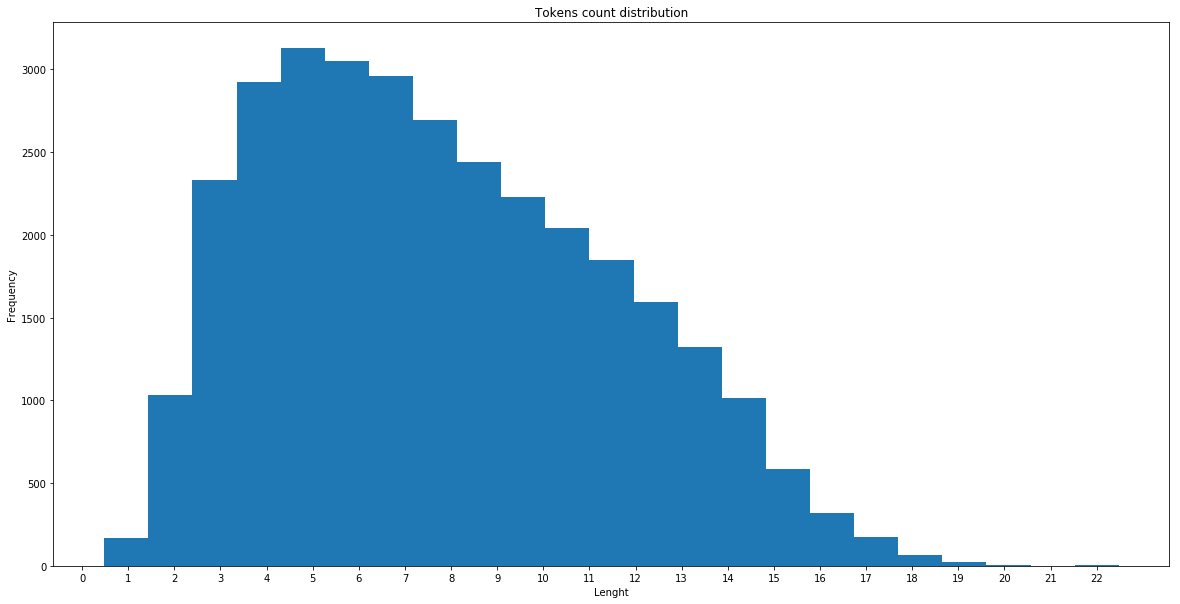

In [6]:
import matplotlib.pyplot as plt

length = df_train['norm_content'].map(len)

plt.figure(figsize=(20,10))
plt.hist(length, bins=(max(length)-min(length)+1), align='right')
plt.title("Tokens count distribution")
plt.xlabel("Lenght")
plt.ylabel("Frequency")
plt.xticks(np.arange(min(length), max(length)+1, 1))
plt.show()

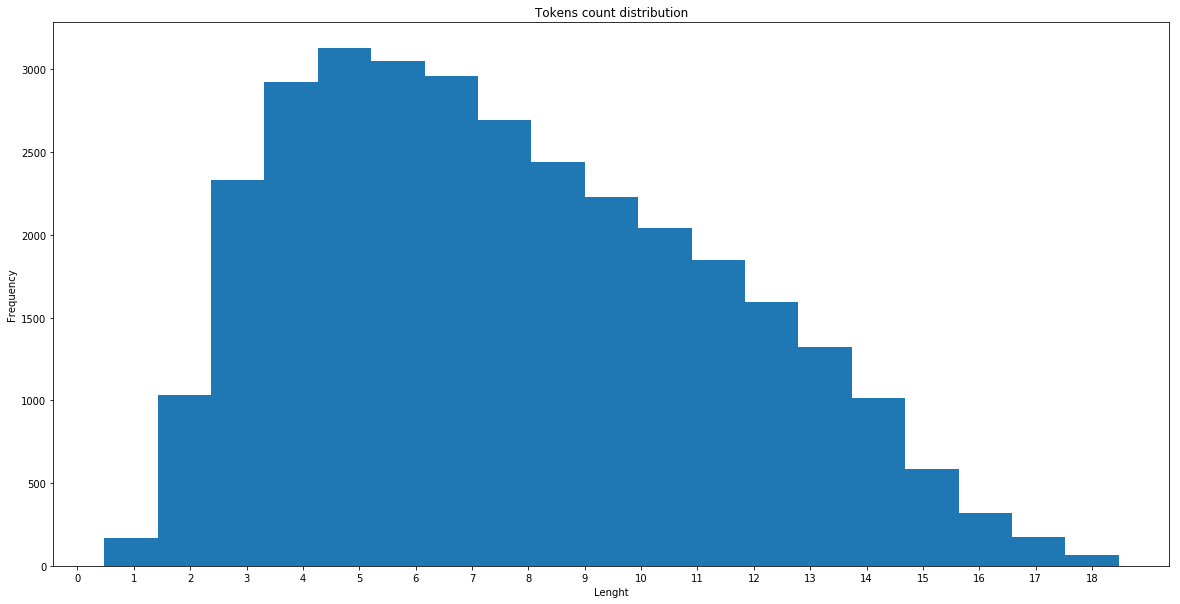

In [7]:
length = df_train['norm_content'].map(len)
df_train = df_train[np.abs(length-length.mean())<=(3*length.std())] 
length = df_train['norm_content'].map(len)

plt.figure(figsize=(20,10))
plt.hist(length, bins=(max(length)-min(length)+1), align='right')
plt.title("Tokens count distribution")
plt.xlabel("Lenght")
plt.ylabel("Frequency")
plt.xticks(np.arange(min(length), max(length)+1, 1))
plt.show()

**d)** Haga una reducción binaria al problema, para trabajarlo como un problema de clasificación de dos clases. Para esto, agrupe las distintas emociones como positivas y negativas (defina un criterio), se recomienda codificar las clases como +1 y −1 respectivamente. Recuerde tener presente que el desbalanceo de los datos puede afectar considerablemente al modelo.

In [8]:
pos = ['neutral', 'happiness', 'love', 'surprise', 'fun', 'relief', 'enthusiasm']

df_train['clase'] = df_train['sentiment'].apply(lambda x: 1 if x in pos else -1)
df_train_df['clase'] = df_train_df['sentiment'].apply(lambda x: 1 if x in pos else -1)

df_test['clase'] = df_test['sentiment'].apply(lambda x: 1 if x in pos else -1)

print(df_train_df['clase'].value_counts()+df_test['clase'].value_counts())
df.head()

 1    23937
-1    16063
Name: clase, dtype: int64


,tweet_id,sentiment,author,content,norm_content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f..."
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call..."
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...,"[funer, ceremoni, ..., gloomi, friday, ...]"
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]"
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]"


**e)** Construir un clasificador que determine automáticamente la polaridad de un trozo de texto.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

def echo(args):
    return args

# Pre-proceso propio
vectorizer = CountVectorizer(tokenizer=echo, preprocessor=echo, lowercase=False)
X_train = vectorizer.fit_transform(df_train['norm_content'])
X_test = vectorizer.transform(df_test['norm_content'])

# Pre-proseso por default de CountVectorizer
vectorizer_df = CountVectorizer()
X_train_df = vectorizer_df.fit_transform(df_train_df['content'])
X_test_df = vectorizer_df.transform(df_test['content'])

**f)** Entrene y compare al menos 5 de los diferentes clasificadores vistos en clases para clasificación binaria (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresión logística, SVM y Arboles de decisión) sobre el conjunto de entrenamiento verificando su desempeño sobre ambos conjuntos (entrenamiento y de pruebas), construyendo un gráfico resumen del error de éstos.

In [10]:
def train(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    
    print(name+" scores:    \t train: %.3f \t test: %.3f"%(score_train,score_test))

    return (name, model, score_train, score_test)

In [11]:
from sklearn.naive_bayes import BernoulliNB
naive_bayes = train("Naive Bayes",BernoulliNB(), X_train, df_train['clase'], X_test, df_test['clase'])
naive_bayes_df = train("Naive Bayes df",BernoulliNB(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

Naive Bayes scores:    	 train: 0.810 	 test: 0.706
Naive Bayes df scores:    	 train: 0.840 	 test: 0.697


In [12]:
from sklearn.naive_bayes import MultinomialNB
multi_naive_bayes = train("Multi Naive Bayes",MultinomialNB(), X_train, df_train['clase'], X_test, df_test['clase'])
multi_naive_bayes_df = train("Multi Naive Bayes df", MultinomialNB(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

Multi Naive Bayes scores:    	 train: 0.821 	 test: 0.709
Multi Naive Bayes df scores:    	 train: 0.863 	 test: 0.710


In [13]:
from sklearn.linear_model import LogisticRegression
logistic = train("LogisticRegression",LogisticRegression(), X_train, df_train['clase'], X_test, df_test['clase'])
logistic_df = train("LogisticRegression df",LogisticRegression(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

LogisticRegression scores:    	 train: 0.834 	 test: 0.713
LogisticRegression df scores:    	 train: 0.884 	 test: 0.718


In [14]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = train("DecisionTree",DecisionTreeClassifier(), X_train, df_train['clase'], X_test, df_test['clase'])
decision_tree_df = train("DecisionTree df",DecisionTreeClassifier(), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

DecisionTree scores:    	 train: 0.992 	 test: 0.635
DecisionTree df scores:    	 train: 0.999 	 test: 0.657


In [15]:
from sklearn.linear_model import SGDClassifier
gradient_descent = train("SGD",SGDClassifier(max_iter=5,tol=None), X_train, df_train['clase'], X_test, df_test['clase'])
gradient_descent_df = train("SGD df",SGDClassifier(max_iter=5,tol=None), X_train_df, df_train_df['clase'], X_test_df, df_test['clase'])

SGD scores:    	 train: 0.804 	 test: 0.712
SGD df scores:    	 train: 0.820 	 test: 0.703


In [38]:
import matplotlib.pyplot as plt
def plot_scores(title,models):
    N = len(models)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.45         # the width of the bars

    fig, ax = plt.subplots()

    test_scores = list(m[2] for m in models)
    train_scores = list(m[3] for m in models)

    rects1 = ax.bar(ind, test_scores, width, color='#00b1ff')
    rects1b = ax.bar(ind+width, train_scores, width, color='#0070ff')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Score')
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels((m[0] for m in models),fontsize='xx-small')

    ax.legend((rects1[0], rects1b[0]), ('Train', 'Test'), loc='lower right')


    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., height,
                    '%.1f%%' % (100*height),
                    ha='center', va='bottom', fontsize='x-small')

    autolabel(rects1)
    autolabel(rects1b)
    fig.set_dpi(170)

    plt.show()

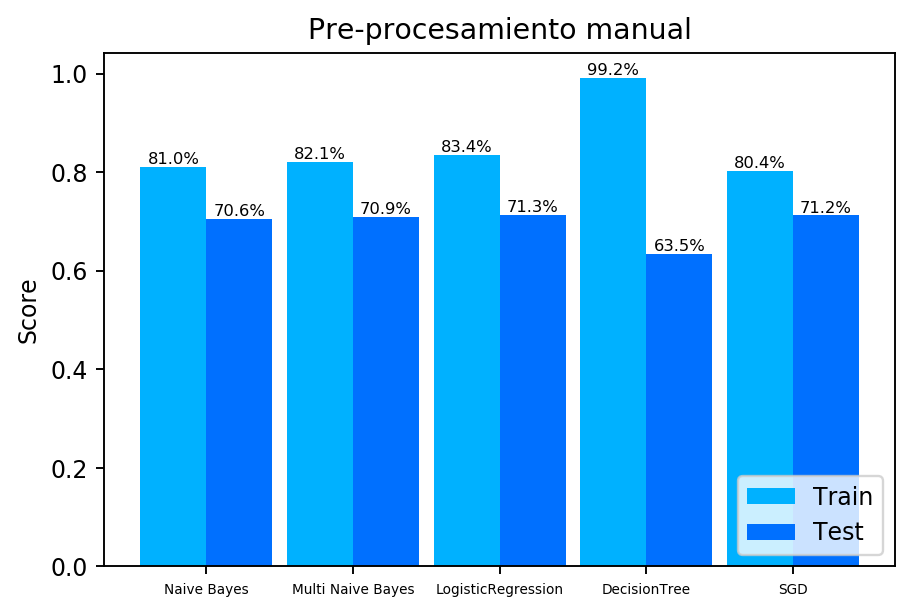

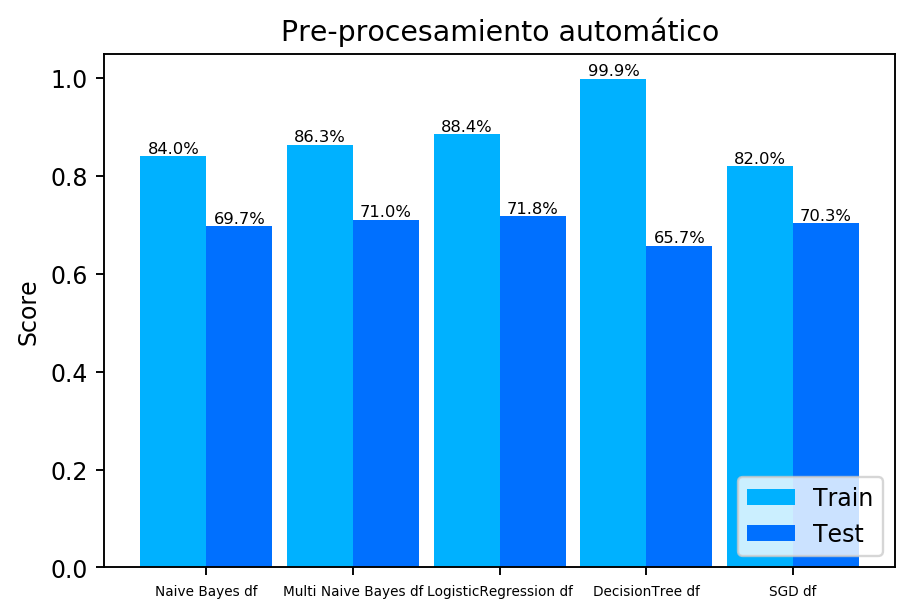

In [39]:
plot_scores("Pre-procesamiento manual",[naive_bayes, multi_naive_bayes, logistic, decision_tree, gradient_descent])
plot_scores("Pre-procesamiento automático",[naive_bayes_df, multi_naive_bayes_df, logistic_df, decision_tree_df, gradient_descent_df])

Cabe notar que modelos como _SVM_, _LDA_ y _QDA_ no fueron posibles de estudiar debido a que las operaciones entre matrices que estos necesitan son muy complicadas, probocando que el cálculo fuera muy largo o simplemente matando el kernel de python.

**g)** Utilice y explique las métricas que calcula la función classification report de la librería sklearn. En base a las distintas métricas calculadas ¿Cuáles clasificadores son los que mejor se comportan?

In [18]:
from sklearn.metrics import classification_report
def score_report(model, X, y):
    name = model[0]
    acc_tr = model[2]
    acc_test = model[3]
    print("Scores for "+name+":")
    print("\tTraining Accuracy: %f"%(acc_tr))
    print("\tTest Accuracy: %f"%(acc_test))
    print("\tDetailed Analysis Testing Results ...")
    print(classification_report(y, model[1].predict(X), target_names=['+','-']))
    print("")

In [19]:
score_report(naive_bayes, X_test, df_test['clase'])
score_report(multi_naive_bayes, X_test, df_test['clase'])
score_report(logistic, X_test, df_test['clase'])
score_report(decision_tree, X_test, df_test['clase'])
score_report(gradient_descent, X_test, df_test['clase'])

Scores for Naive Bayes:
	Training Accuracy: 0.810066
	Test Accuracy: 0.705809
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.69      0.49      0.57      3218
          -       0.71      0.85      0.78      4804

avg / total       0.70      0.71      0.69      8022


Scores for Multi Naive Bayes:
	Training Accuracy: 0.821491
	Test Accuracy: 0.708676
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.65      0.58      0.62      3218
          -       0.74      0.79      0.77      4804

avg / total       0.70      0.71      0.71      8022


Scores for LogisticRegression:
	Training Accuracy: 0.834262
	Test Accuracy: 0.712914
	Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

          +       0.68      0.54      0.60      3218
          -       0.73      0.83      0.78      4804

avg / total       0.71      0.71      0.71 

**_f1-score_** puede ser interpretado como el promedio poderado de _precision_ y _recall_, siendo 0 y 1 los puntajes mínimos y máximos respectivamente.

**_precision_** está definido por $\frac{tp}{tp+fp}$, donde $tp$ y $fp$ son la cantidad de verdaderos y falsos positivos respectivamente, es decir, _precision_ denota la habilidad del clasificador de no etiquetar una muestra que es negativa como positiva.

**_recall_** está definido por $\frac{tp}{tp+fn}$, donde $fn$ es el número de falsos negativos. _recall_ denota la habilidad del clasificador de etiquetar todas las muestras positivas como positiva. 

**_support_** corresponde al número de ocurrencias de cada clase.

**h)** [Opcional] Visualice las predicciones de algún modelo generativo (probabilístico) definido anteriormente, tomando un subconjunto aleatorio de tweets de pruebas y explorando las probabilidades que asigna el clasificador a cada clase.

In [20]:
import random
random.seed(14)
test_pred = logistic[1].predict_proba(X_test)
spl = random.sample(range(len(test_pred)), 15)

print("Negative \t Positive \t Tweet")
for i in spl:
    print(test_pred[i],"\t",df_test.reset_index()['content'][i])

Negative 	 Positive 	 Tweet
[ 0.53040068  0.46959932] 	 On my way to work wish I had more days off
[ 0.18207551  0.81792449] 	 @AprilAMiller Its 5:30 in the evening, sunset time
[ 0.30955312  0.69044688] 	 @mamapigeon I be ok, you?
[ 0.18336581  0.81663419] 	 watchin family guy
[ 0.14601978  0.85398022] 	 @BeSharp wow, great to know a piece of software ensures our timely project delivery  #ProductNamingRulez
[ 0.15249008  0.84750992] 	 @rachky @taltalush Yes. I am secure in my masculinity.
[ 0.08708496  0.91291504] 	 @issacfourth haha dork .. That sounds so yummy .. Share!
[ 0.19411173  0.80588827] 	 @cowmage  read something happy?
[ 0.85670514  0.14329486] 	 Ugh just got out of work i think i'm a dang taxi for ppl but i just can't say no!!!!  o well its my fault
[ 0.72362991  0.27637009] 	 @yourself_onfire I think Letitia is still trying to upload the digital, they were having problems before. I am sure she will let us know
[ 0.63847123  0.36152877] 	 http://twitpic.com/675u6 - Square

**i)** Ahora deberá extender el problema a las múltiples clases que tiene presente (las distintas emociones), es decir, su trabajo será el de predecir una de las distintas emociones de cada _tweet_. Para esto utilice el mismo pre-procesamiento realizado en el punto c) y las características generadas mediante las técnicas en el punto e). Recuerde que tendrá que codificar las distintas clases como valores numéricos enteros.

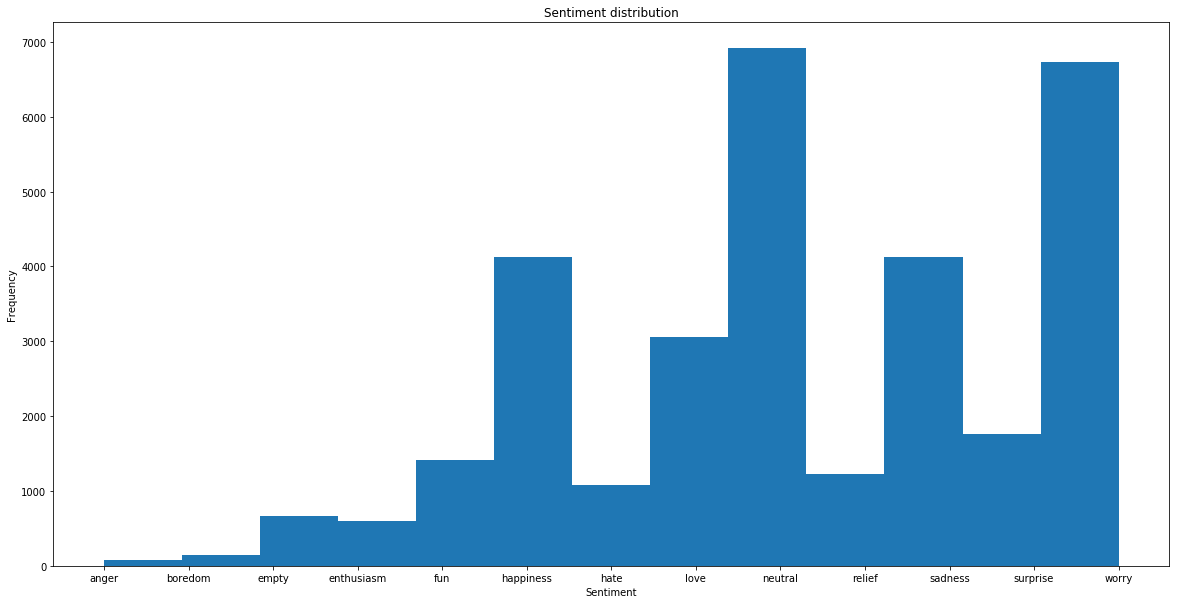

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.hist(df_train['sentiment'], bins=13)
plt.title("Sentiment distribution")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

In [22]:
clases['value']=[0,-1,1,-2,2,3,4,5,-3,-4,6,-5,-6]
sent = list(clases['sentiment'])
sent_v = list(clases['value'])
df_train['sentiment_class'] = df_train['sentiment'].apply(lambda x: sent_v[sent.index(x)])
df_test['sentiment_class'] = df_test['sentiment'].apply(lambda x: sent_v[sent.index(x)])

df_train.head()

,tweet_id,sentiment,author,content,norm_content,clase,sentiment_class
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...,"[know, listenin, bad, habit, earlier, start, f...",-1,-4
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...,"[layin, bed, headach, ughhh, ..., waitin, call...",-1,-2
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!,"[want, hang, friend, soon]",1,6
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...,"[want, trade, someon, houston, ticket, one]",1,0
6,1956968487,sadness,ShansBee,"I should be sleep, but im not! thinking about ...","[sleep, think, old, friend, want, he', marri, ...",-1,-2


**j)** Utilice los clasificadores que son extendidos por defecto a múltiples clases para detectar emociones en cada _tweet_, muestre sus desempeños a través del error de pruebas en un gráfico resumen.

In [32]:
dt = train("DecisionTree",DecisionTreeClassifier(), X_train, df_train['sentiment_class'], X_test, df_test['sentiment_class'])
mnb = train("MultinomialNB",MultinomialNB(), X_train, df_train['sentiment_class'], X_test, df_test['sentiment_class'])
#mlp = train("Multi-layer Perceptron",MLPClassifier(), X_train, df_train['sentiment_class'], X_test, df_test['sentiment_class'])

DecisionTree scores:    	 train: 0.979 	 test: 0.269
MultinomialNB scores:    	 train: 0.523 	 test: 0.323


Gráfico en item **m)**

**k)** Utilice clasificadores binarios que pueden ser extendidos a través de otras técnicas, tal como One vs One y One vs All/Rest.

In [48]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

nb_ovo = train("Naive Bayes OVO",OneVsOneClassifier(BernoulliNB()), X_train, df_train['sentiment_class'], X_test, df_test['sentiment_class'])
nb_ovr = train("Naive Bayes OVR",OneVsRestClassifier(BernoulliNB()), X_train, df_train['sentiment_class'], X_test, df_test['sentiment_class'])

Naive Bayes OVO scores:    	 train: 0.449 	 test: 0.314
Naive Bayes OVR scores:    	 train: 0.488 	 test: 0.321


**l)** Para el caso de la Regresión Logística compare sus dos métodos para ser extendidos a múltiples clases. Uno a través de One vs Rest y otro definiendo que la variable a predecir se distribuye Multinomial.

In [51]:
lr_mtn = train("Log. Reg. Multi",LogisticRegression(), X_train, df_train['sentiment_class'], X_test, df_test['sentiment_class'])
lr_ovr = train("Log. Reg. OVR",OneVsRestClassifier(LogisticRegression()), X_train, df_train['sentiment_class'], X_test, df_test['sentiment_class'])

Log. Reg. Multi scores:    	 train: 0.647 	 test: 0.341
Log. Reg. OVR scores:    	 train: 0.647 	 test: 0.341


**m)** Compare los resultados entre los clasificadores extendidos por defecto y los binarios que son extendidos mediante otras técnicas, construya una tabla o gráfico resumen. Los clasificadores que mejor se comportan en el caso binario ¿Siguen teniendo ese desempeño en múltiples clases?

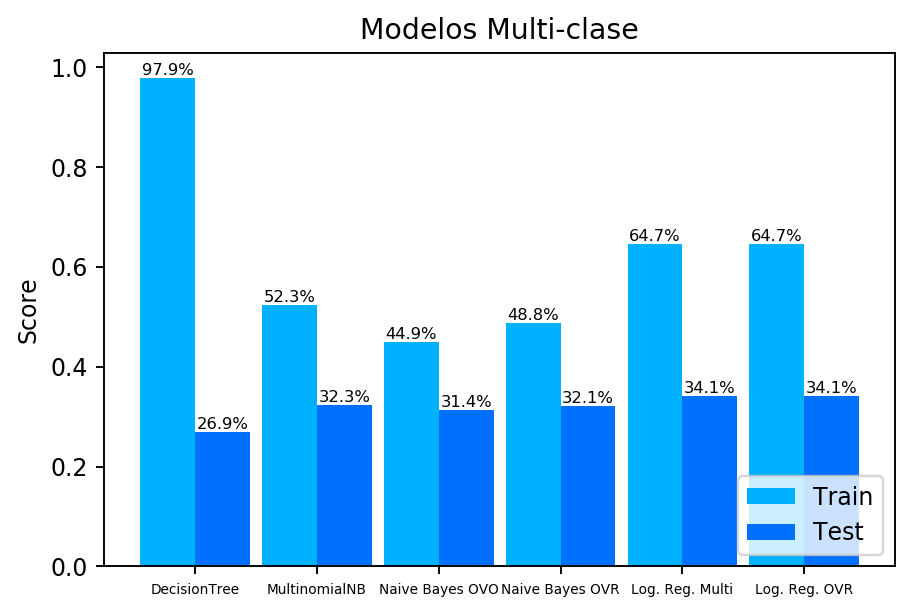

In [52]:
plot_scores("Modelos Multi-clase",[dt, mnb, nb_ovo, nb_ovr, lr_mtn, lr_ovr])

Aquí nuevamente la regresión logística vuelve a obtener un score por sobre las otras técnicas, aúnque la diferencia es decimal.

Como se puede notar a simple vista, las diferencias de desempeño que hay entre la clasificación binaria y la multiclase es muy grande, esto puede ser debido principalmente a que la cantidad de datos que se posee no es suficiente para la multiclase, ya que por ejemplo para los tweets clasificados como _empty_, _enthusiasm_, _boredom_, y _anger_ se tienen entre 900 y 100 muestras, lo que hace que las predicciones sean muy poco "educadas", resultando en los errores mostrados. Esto no ocurre en el caso binario, ya que cada clase tiene al menos 16.000 muestras, siendo así un dataset aceptable para el experimento.